In [389]:
# this part of the codes fetches requirements
import hashlib
from phe import paillier
import random as rd
import numpy as np
from timeit import default_timer as timer
import matplotlib.pyplot as plt


In [390]:
listOfIDS = []
dictionaryOfPublicKeys = {}
dictionaryOfPrivateKeys = {}
dictionaryOfRandomNumbers = {}
dictionaryOfBids = {}
finalSubmittedDataFirstPhase = [] #will be sused to stored the final resuklt of the two bidder for bid submission
highestbidder = 0 
numberOfBidders = 0 
publicKeyAuc, privateKeyAuc = 0, 0
finalDataOfSecondPhase = []

In [391]:
#  this part of the code creates unique BID for all participants
def createBiddersAndKeys(n):
  global numberOfBidders,dictionaryOfPublicKeys,dictionaryOfPrivateKeys,privateKeyAuc,publicKeyAuc,listOfIDS
  publicKeyAuc = 0
  privateKeyAuc = 0
  numberOfBidders = n
  listOfIDS =[]
  dictionaryOfPrivateKeys = {}
  dictionaryOfPublicKeys = {}
  for i in range(0,numberOfBidders):
    i = str(i)
    listOfIDS.append(hashlib.sha256(i.encode('utf-8')).hexdigest())
  i = 0
  publicKeyAuc, privateKeyAuc = paillier.generate_paillier_keypair(n_length= 128)
  for i in range(0, numberOfBidders):
    x,y = paillier.generate_paillier_keypair(n_length= 256)
    dictionaryOfPublicKeys[listOfIDS[i]],dictionaryOfPrivateKeys[listOfIDS[i]]  = x ,y
  i = 0

end of the Registration phase and start of Bid Submission Phase

In [392]:
# this part of the code generate random number and distinct bid values for all bidders and Auctioneer
def  createRandomNumberAndBids():
    global dictionaryOfBids, dictionaryOfRandomNumbers
    dictionaryOfBids, dictionaryOfRandomNumbers = {},{}
    bids  = rd.sample(range(1, numberOfBidders+1 ), numberOfBidders)
    for i in range(0,numberOfBidders):
        r  = rd.randint(100,10000)
        dictionaryOfRandomNumbers[listOfIDS[i]] =  r
        dictionaryOfBids[listOfIDS[i]] = bids[i]
    i = 0
    # print(dictionaryOfBids)
    # print(dictionaryOfRandomNumbers)
    # initFirstPhase()


In [393]:
# this PART OF THE CODE SIMULATES BIDDER GENERATING PRODUCT AND THAN SENDING TO NEXT BIDDER

def initFirstPhase():
    global finalSubmittedDataFirstPhase
    finalSubmittedDataFirstPhase = []
    for i in range(0,numberOfBidders):
        id = listOfIDS[i]
        dataPerBidder= []
        encrytionOfBidAndRandomNumber = publicKeyAuc.raw_encrypt(dictionaryOfBids[id] + dictionaryOfRandomNumbers[id])
        # this part of code is forwarding the encrytionOfBidAndRandomNumber to all other bidders and after addition of the random number of the next bidder it is sent to the Auctioneer immediately
        for j in range(0,numberOfBidders):
            if j != i:
                idOfNextBidder = listOfIDS[j]
                pubKeyNextBidder, priKeyNextBidder= dictionaryOfPublicKeys[idOfNextBidder],dictionaryOfPrivateKeys[idOfNextBidder]
                e = pubKeyNextBidder.raw_encrypt(encrytionOfBidAndRandomNumber)
                e = priKeyNextBidder.raw_decrypt(e)
                encrytionOfBidAndBothRandomNumber = e *  publicKeyAuc.raw_encrypt(dictionaryOfRandomNumbers[idOfNextBidder]) 
                # this part of the code simulates the storing of the data of the bid summision to auctioneer data
                dataPerBidder.append(privateKeyAuc.raw_decrypt(encrytionOfBidAndBothRandomNumber))
            else:
                dataPerBidder.append(0)
        finalSubmittedDataFirstPhase.append(dataPerBidder)
    i,j = 0,0
    

implementation of the second phase here auctioneer reforward each packet to every bidder to multiply their random number.

In [394]:
def everyBiddersRandomNumberAddition(encryptedAuctioneerRandomNumber):
    output = encryptedAuctioneerRandomNumber
    for i in range(numberOfBidders):     
        output  = (output * publicKeyAuc.raw_encrypt(dictionaryOfRandomNumbers[listOfIDS[i]]))
    return output

In [395]:
def initSecondPhase():
    global finalDataOfSecondPhase
    finalDataOfSecondPhase = []
    auctioneerRandomNumber = rd.randint(2,2000)
    print(auctioneerRandomNumber)
    for i in range(numberOfBidders):
        dataPerBidder = []
        for j in range(numberOfBidders):
            if finalSubmittedDataFirstPhase[i][j] == 0 :
                dataPerBidder.append(0)
            else:
                encryptedValueByAuctioneer = publicKeyAuc.raw_encrypt(auctioneerRandomNumber)
                returnValue = everyBiddersRandomNumberAddition(encryptedValueByAuctioneer)
                dataPerBidder.append((privateKeyAuc.raw_decrypt(returnValue))+finalSubmittedDataFirstPhase[i][j])
        finalDataOfSecondPhase.append(dataPerBidder)
    i,j = 0,0

In [396]:
def printMatrices():
    for i in range(len(finalSubmittedDataFirstPhase)):
        print(finalSubmittedDataFirstPhase[i])
    i = 0
    print("second matrix get printed from here")
    for i in range(len(finalDataOfSecondPhase)):
        print(finalDataOfSecondPhase[i])
    i = 0

In [397]:

#this part of the code checks if all the entered values for SMPC are correct or not
# this works for a step of one
def verifyTheData():
    for i in range(numberOfBidders):
        sum = 0
        for j in range(numberOfBidders):
            if j + i < numberOfBidders:
                sum = sum + finalSubmittedDataFirstPhase[j][j+i]
            else:
                sum = sum + finalSubmittedDataFirstPhase[j][(j+i)% numberOfBidders]
        print(sum)
    # .........................................................................#...........................................  
    # this works for any random step that has been taken in range (1,numberOfBidders) 
    # k = rd.randint(1,numberOfBidders)
    # print(k)
    # for i in range(numberOfBidders-1):
    #     sum = 0
    #     for j in range(numberOfBidders):
    #         if j + k < numberOfBidders:
    #             sum = sum + finalDataOfSecondPhase[j][j+k]
    #         else:
    #             #we took the mod so that the next bidder value should come to the range from the number of the bidders
    #             sum = sum + finalDataOfSecondPhase[j][(j+k)% numberOfBidders]
    #     print(sum)  
    i,j = 0,0

In [398]:
# this function chjoosews the best buyer based on the comparison it works as the auctrioneer is comparing each pair

def chooseBestBuyer():
    global highestbidder
    highestbidder = 0
    for i in range(0,numberOfBidders):
        highestbidder = i
        for j in range(0,numberOfBidders):
            if i != j:
                if finalDataOfSecondPhase[i][j] < finalDataOfSecondPhase[j][i]:
                    highestbidder  = j
                    i = j
            else:
                continue
    i = 0
    print(highestbidder)

In [399]:
def runSimulation(m):
    createBiddersAndKeys(m)
    createRandomNumberAndBids()
    initFirstPhase()
    initSecondPhase()
    # printMatrices()
    verifyTheData()
    chooseBestBuyer()
    for i in range(numberOfBidders):
        print(dictionaryOfBids[listOfIDS[i]],end = " ")

In [400]:
runSimulation(9)


489
0
77071
77071
77071
77071
77071
77071
77071
77071
4
6 4 2 7 9 8 1 3 5 

In [401]:
bidderSizes = [10,20,30,50,70,90,100,150,200,300,500,800,1000]
timeList = []
for i in range(len(bidderSizes)):
    start = timer()
    runSimulation(bidderSizes[i])
    end = timer()
    print(end-start)
    timeList.append(end-start)  
i = 0

772
0
120949
120949
120949
120949
120949
120949
120949
120949
120949
2
2 8 10 3 4 5 6 7 9 1 0.11817280700051924
915
0
164368
164368
164368
164368
164368
164368
164368
164368
164368
164368
164368
164368
164368
164368
164368
164368
164368
164368
164368
18
2 5 3 1 6 16 14 12 18 7 19 9 4 8 17 11 10 15 20 13 0.5607178950012894
1652
0
302823
302823
302823
302823
302823
302823
302823
302823
302823
302823
302823
302823
302823
302823
302823
302823
302823
302823
302823
302823
302823
302823
302823
302823
302823
302823
302823
302823
302823
14
15 14 5 8 3 27 16 10 17 18 12 20 6 26 30 29 22 21 4 11 25 1 2 19 13 28 9 23 7 24 1.757291001998965
477
0
507045
507045
507045
507045
507045
507045
507045
507045
507045
507045
507045
507045
507045
507045
507045
507045
507045
507045
507045
507045
507045
507045
507045
507045
507045
507045
507045
507045
507045
507045
507045
507045
507045
507045
507045
507045
507045
507045
507045
507045
507045
507045
507045
507045
507045
507045
507045
507045
507045
13
21 26 33 20 

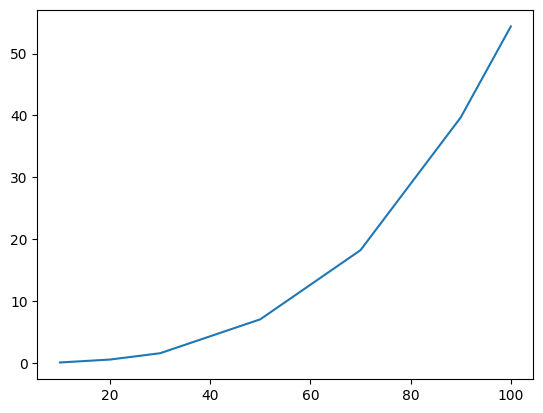

In [ ]:
plt.plot(bidderSizes,timeList)

In [ ]:
timeList

[0.13257937299931655, 0.605084587001329, 1.624472870000318, 7.100093077002384, 18.25974657700135, 39.68040298699998, 54.36666493600205]
